# 2. Simple CNN - Creazione di una Baseline

In questo notebook costruiremo, addestreremo e valuteremo una Rete Neurale Convoluzionale (CNN) semplice partendo da zero. L'obiettivo è creare una "baseline", ovvero un modello di riferimento le cui performance cercheremo di superare con tecniche più avanzate.

## 1. Setup dell'Ambiente
### 1.1 Import delle Librerie
Importiamo TensorFlow, Keras e le altre librerie necessarie per la creazione e la visualizzazione del modello.

In [1]:
# --- Framework di Deep Learning ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Librerie per la visualizzazione e l'analisi ---
import matplotlib.pyplot as plt
import numpy as np

# --- Librerie di sistema per la gestione dei percorsi ---
import os
import pathlib

print(f"✅ Librerie importate correttamente.")
print(f"Versione di TensorFlow: {tf.__version__}")

✅ Librerie importate correttamente.
Versione di TensorFlow: 2.19.0


### 1.2 Definizione dei Percorsi e delle Costanti
Definiamo le costanti del progetto, come il percorso ai dati, le dimensioni delle immagini e la grandezza dei batch.

In [2]:
# --- Percorsi ---
# Definiamo il percorso principale del progetto salendo di un livello dalla cartella /notebooks
PROJECT_ROOT = pathlib.Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / 'data' / 'raw' / 'Garbage classification'

# --- Parametri del Modello ---
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
# La tupla delle dimensioni che Keras si aspetta (altezza, larghezza)
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

# --- Parametri di Addestramento ---
BATCH_SIZE = 32 # Quante immagini processare alla volta
EPOCHS = 15     # Quante volte il modello vedrà l'intero dataset
NUM_CLASSES = 6 # Il numero di classi che abbiamo identificato nell'EDA

print("✅ Costanti del progetto definite.")
print(f"Percorso dati: {DATA_DIR}")
print(f"Dimensioni input: {IMG_SIZE}")

✅ Costanti del progetto definite.
Percorso dati: /Users/andrea_difelice/garbage-classifier/data/raw/Garbage classification
Dimensioni input: (224, 224)


## 2. Preparazione dei Dati
### 2.1 Creazione dei Dataset di Training e Validazione
Useremo l'utility `image_dataset_from_directory` di Keras per caricare le immagini direttamente dalle cartelle e suddividerle in un set di addestramento (80%) e uno di validazione (20%). Questo creerà dei `tf.data.Dataset` ottimizzati per le performance.

In [3]:
# --- Creazione del Dataset di Addestramento (80% dei dati) ---
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# --- Creazione del Dataset di Validazione (20% dei dati) ---
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Otteniamo i nomi delle classi dal dataset
class_names = train_dataset.class_names
print(f"✅ Classi trovate: {class_names}")

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
✅ Classi trovate: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


### 2.2 Configurazione per le Performance
Configuriamo i dataset con prefetching e caching per velocizzare la fase di addestramento.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset ottimizzati per le performance con caching e prefetching.")

Dataset ottimizzati per le performance con caching e prefetching.


## 3. Costruzione del Modello
### 3.1 Definizione dell'Architettura
Creiamo un modello `Sequential` con una struttura standard:
- Un layer di **Rescaling** per normalizzare i valori dei pixel da [0, 255] a [0, 1].
- Alcuni blocchi di `Conv2D` e `MaxPooling2D` per estrarre le features.
- Un layer `Flatten` per trasformare i dati in un vettore.
- Un layer `Dense` con attivazione ReLU.
- Un layer `Dense` di output con attivazione `softmax` per la classificazione.

In [5]:
# Crea il modello sequenziale
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax') # Output layer
])

# Mostra un riepilogo dell'architettura
model.summary()

/Users/andrea_difelice/garbage-classifier/venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,014 (24.59 MB)

 Trainable params: 6,447,014 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Compilazione del Modello
Compiliamo il modello specificando l'ottimizzatore (`Adam`), la funzione di costo (`SparseCategoricalCrossentropy`) e le metriche da monitorare (`accuracy`).

In [6]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Modello compilato correttamente.")

Modello compilato correttamente.


## 4. Addestramento del Modello
### 4.1 Esecuzione del Training
Addestriamo il modello usando il metodo `model.fit()`, passando i dati di training e di validazione. Salveremo lo storico dell'addestramento per analizzarlo in seguito.

In [7]:
print("Inizio addestramento del modello...")

history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=EPOCHS
)

print("Addestramento completato.")

Inizio addestramento del modello...
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 283ms/step - accuracy: 0.3134 - loss: 1.7470 - val_accuracy: 0.5089 - val_loss: 1.2454
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.5247 - loss: 1.2140 - val_accuracy: 0.5762 - val_loss: 1.1509
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 258ms/step - accuracy: 0.6316 - loss: 0.9797 - val_accuracy: 0.6119 - val_loss: 1.0753
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.7143 - loss: 0.7725 - val_accuracy: 0.5941 - val_loss: 1.2052
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.8069 - loss: 0.5511 - val_accuracy: 0.4713 - val_loss: 1.7213
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.7909 - loss: 0.5524 - val_accuracy: 0.5941 - val_loss: 1.4576
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - accuracy: 0.8666 - loss: 0.3913 - val_accuracy: 0.5525 - val_loss: 1.8645
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - accura

### 4.2 Salvataggio del Modello
Salviamo i pesi del modello addestrato per poterlo riutilizzare in futuro senza doverlo riaddestrare.

In [8]:
# --- Creiamo la cartella per i modelli se non esiste ---
models_dir = PROJECT_ROOT / 'models'
models_dir.mkdir(exist_ok=True)

# --- Definiamo il percorso completo per il file del modello ---
model_save_path = models_dir / 'simple_cnn_baseline.keras'

# --- Salviamo il modello ---
model.save(model_save_path)

print(f"Modello salvato correttamente in: {model_save_path}")

Modello salvato correttamente in: /Users/andrea_difelice/garbage-classifier/models/simple_cnn_baseline.keras


## 5. Valutazione delle Performance
### 5.1 Visualizzazione delle Curve di Apprendimento
Creiamo un grafico che mostra l'andamento della `accuracy` e della `loss` di training e validazione nel tempo (epoche). Questo è fondamentale per capire se il modello sta imparando correttamente e se c'è overfitting.

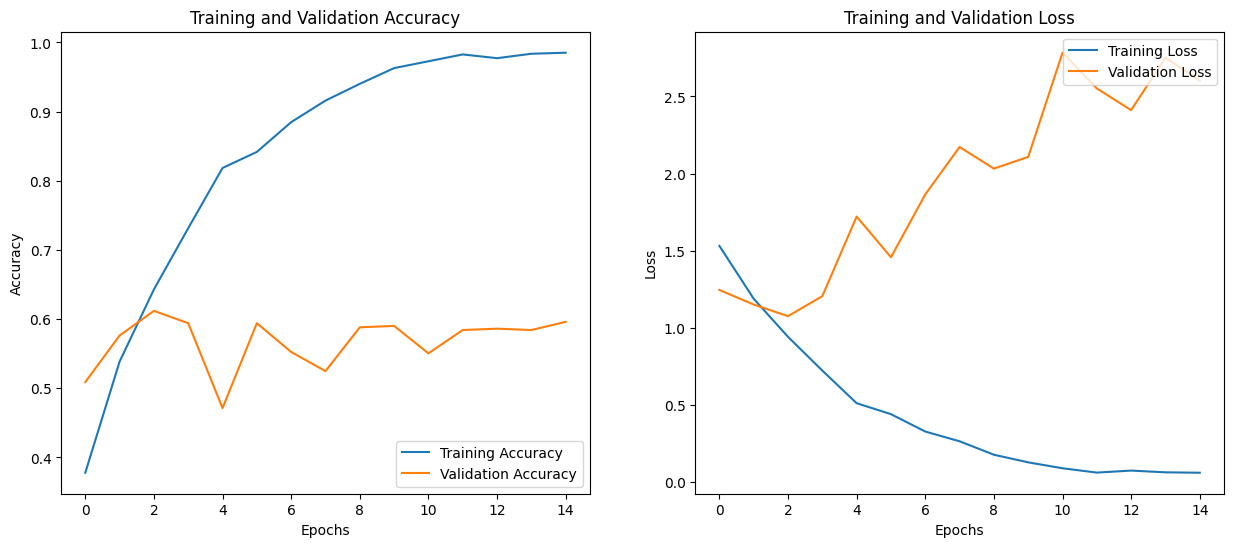

In [9]:
# Estrai i dati dalla cronologia dell'addestramento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

# Crea la figura per i grafici
plt.figure(figsize=(15, 6))

# Grafico per l'Accuratezza
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Grafico per la Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Mostra i grafici
plt.show()

2025-07-29 17:39:27.961085: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


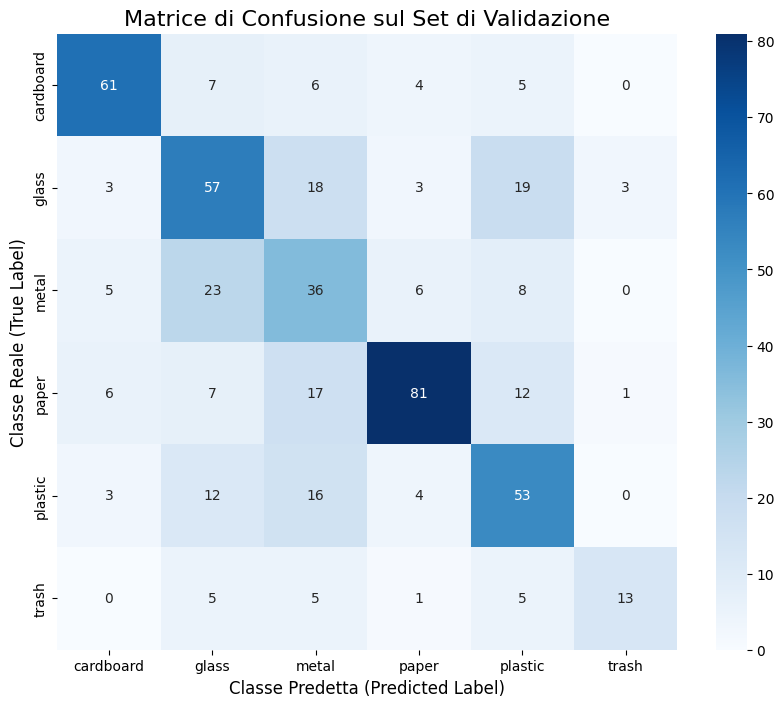

In [10]:
# Importiamo le librerie necessarie
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Dobbiamo ottenere le etichette reali e le predizioni dal validation_dataset
# Iteriamo sul dataset per estrarle
y_true = []
y_pred_probs = []

for images, labels in validation_dataset:
    y_true.extend(labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred_probs.extend(preds)

# Convertiamo le probabilità in classi predette (l'indice con la probabilità più alta)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcoliamo la matrice di confusione
cm = confusion_matrix(y_true, y_pred)

# Visualizziamo la matrice di confusione con una heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Matrice di Confusione sul Set di Validazione', fontsize=16)
plt.ylabel('Classe Reale (True Label)', fontsize=12)
plt.xlabel('Classe Predetta (Predicted Label)', fontsize=12)
plt.show()

## 6. Conclusioni sulla Baseline

L'addestramento della nostra CNN semplice ha fornito risultati estremamente chiari e informativi, stabilendo una baseline di performance e mettendo in luce i limiti di un approccio base.

### Analisi delle Performance

1.  **Overfitting Evidente**: Le curve di apprendimento mostrano un classico caso di overfitting. Mentre l'accuratezza sul training set sfiora il 100%, quella sul validation set si assesta su un modesto **55-60%**. La divergenza netta tra le curve di loss di training (in calo) e di validazione (in aumento) è il segnale inequivocabile che il modello sta "memorizzando" i dati di training invece di generalizzare.

2.  **Errori Specifici (Matrice di Confusione)**: La matrice di confusione ha confermato le previsioni fatte durante l'EDA. Il modello:
    * È relativamente competente nel distinguere `paper` e `cardboard`.
    * Mostra una **forte confusione** tra le classi visivamente simili come `glass`, `metal` e `plastic`.
    * Ha performance molto scarse sulla classe `trash`, la più generica e meno rappresentata.

### Risultato Finale

Abbiamo stabilito una **baseline di accuratezza di circa 55-60%**. Questo è il nostro punto di partenza. L'analisi ha dimostrato che una CNN semplice non ha la capacità sufficiente per gestire la variabilità e le somiglianze del nostro dataset, portando a un forte overfitting.

Nel prossimo e ultimo notebook, **`Transfer_Learning.ipynb`**, affronteremo direttamente questo problema utilizzando tecniche più avanzate come il **Transfer Learning** e l'**Image Augmentation** per superare significativamente questa baseline.